<a href="https://colab.research.google.com/github/LoPA607/IE643_project/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade diffusers transformers accelerate safetensors


✅ Using device: CUDA

🚀 Loading Stable Diffusion pipeline...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Pipeline loaded successfully!

📤 Upload the STYLE image:


Saving hidemotionblur.png to hidemotionblur (4).png
✅ Style image 'hidemotionblur (4).png' loaded.

📤 Upload the CONTENT image:


Saving clean.jpg to clean (4).jpg
✅ Content image 'clean (4).jpg' loaded.



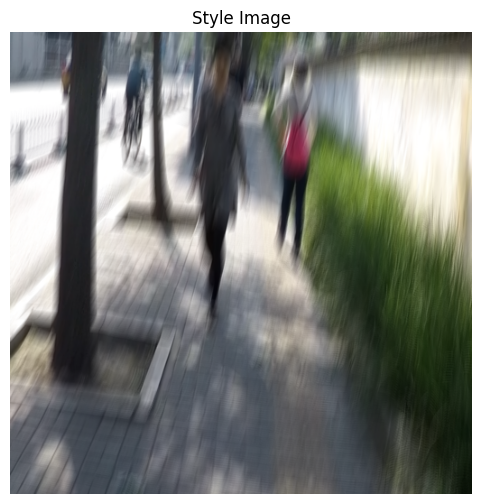

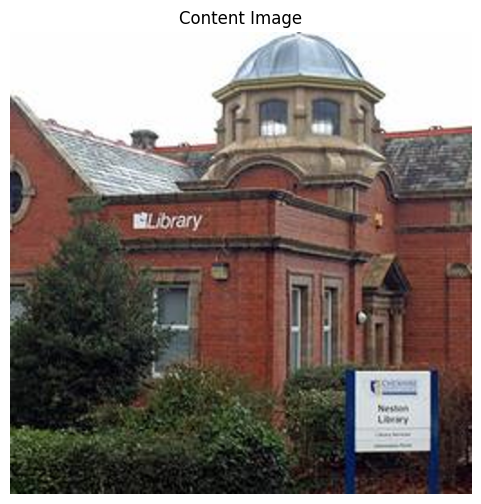

🔄 Encoding both images into latent space...
✅ Encoded both images into latents!

🧮 Blending latents (style strength = 0.3) ...
✅ Latents blended successfully!

🖼️ Decoding blended latent to get final image...


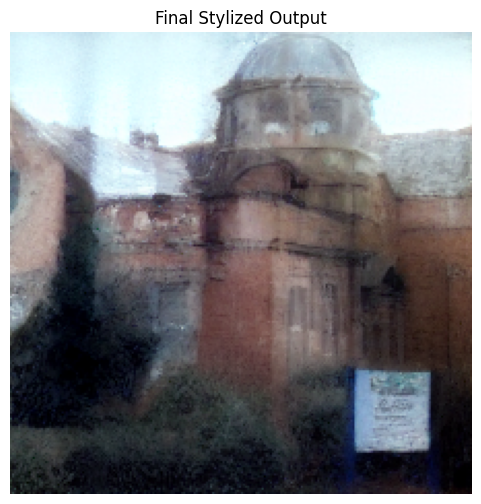

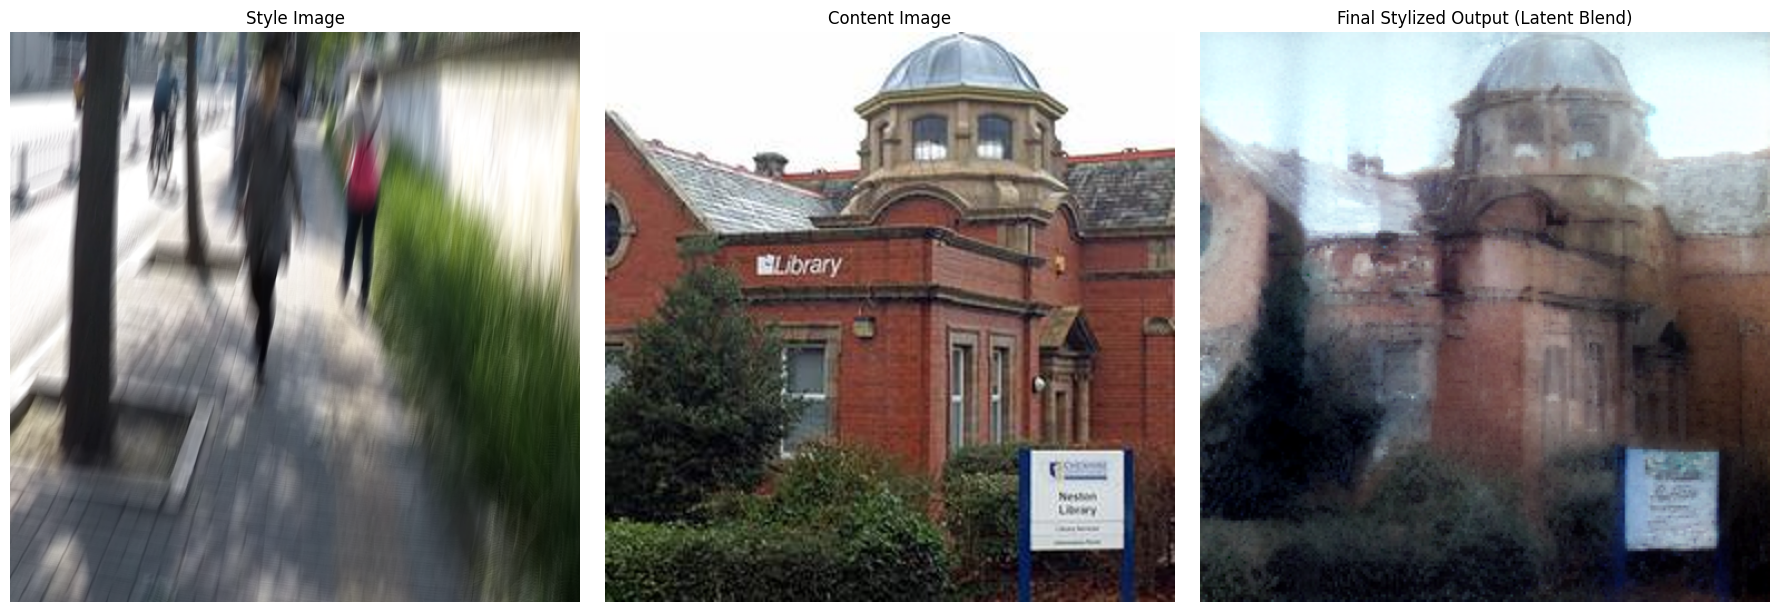

💾 Saved as 'stylized_output.png'
✅ One-shot style transfer completed successfully! 🎨✨


In [ ]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device.upper()}")

def show_image(img, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()


# === Load SD pipeline ===
print("\n🚀 Loading Stable Diffusion pipeline...")
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)
pipe.enable_attention_slicing()
print("✅ Pipeline loaded successfully!\n")


# === Upload images ===
print("📤 Upload the STYLE image:")
uploaded_style = files.upload()
style_path = list(uploaded_style.keys())[0]
style_img = Image.open(style_path).convert("RGB").resize((512,512))
print(f"✅ Style image '{style_path}' loaded.")

print("\n📤 Upload the CONTENT image:")
uploaded_content = files.upload()
content_path = list(uploaded_content.keys())[0]
content_img = Image.open(content_path).convert("RGB").resize((512,512))
print(f"✅ Content image '{content_path}' loaded.\n")

show_image(style_img, "Style Image")
show_image(content_img, "Content Image")


# === Encode both images into latents ===
print("🔄 Encoding both images into latent space...")

def encode_image(img):
    img_tensor = pipe.feature_extractor(images=img, return_tensors="pt").pixel_values.to(device, dtype=torch.float16)
    latents = pipe.vae.encode(img_tensor).latent_dist.sample() * 0.18215
    return latents

style_latent = encode_image(style_img)
content_latent = encode_image(content_img)
print("✅ Encoded both images into latents!\n")


# === Blend latents ===
alpha = 0.3  # 0.3 = light style, 0.7 = strong style
print(f"🧮 Blending latents (style strength = {alpha}) ...")
blended_latent = (1 - alpha) * content_latent + alpha * style_latent
print("✅ Latents blended successfully!\n")


# === Decode blended latent back to image ===
print("🖼️ Decoding blended latent to get final image...")
with torch.no_grad():
    decoded_img = pipe.vae.decode(blended_latent / 0.18215).sample

decoded_img = (decoded_img / 2 + 0.5).clamp(0, 1)
decoded_img = decoded_img.cpu().permute(0, 2, 3, 1).float().numpy()[0]
decoded_img_pil = Image.fromarray((decoded_img * 255).astype("uint8"))

show_image(decoded_img_pil, "Final Stylized Output")
decoded_img_pil.save("stylized_output.png")

# === Summary ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(style_img)
axes[0].set_title("Style Image")
axes[0].axis("off")

axes[1].imshow(content_img)
axes[1].set_title("Content Image")
axes[1].axis("off")

axes[2].imshow(decoded_img_pil)
axes[2].set_title("Final Stylized Output (Latent Blend)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("💾 Saved as 'stylized_output.png'")
print("✅ One-shot style transfer completed successfully! 🎨✨")
